In [1]:
#Genetic Algorithm to Trade Stocks Based on Indicators (GATSBI)

from pandas_datareader.data import DataReader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import random
from progress.bar import IncrementalBar

In [2]:
start_date = '2005/01/01'
end_date = '2022/05/16'
my_year_month_fmt = mdates.DateFormatter('%m/%y')

In [3]:
class Agent():
    def __init__(self, cash):
        self.cash = cash
        self.init_cash = cash
        self.stock = 0
        self.position = "long"
        self.g = []
        for i in range(5):
            self.g.append(0)
        self.date_history = []
        self.trans_history = []

    def reset(self):
        self.cash = self.init_cash
        self.stock = 0
        self.position = "long"
        self.date_history = []
        self.trans_history = []
    def randomize(self):
        for i in range(5):
            self.g[i] = random.uniform(-1,1)

    def evaluate(self, data):
        det = data[0]*self.g[0] + data[1]*self.g[1] + data[2]*self.g[2] + data[3]*self.g[3] + data[4]*self.g[4]
        if det>=0:
            self.position = "long"
        if det<0:
            self.position = "short"
        return self.position
    
    def execute(self, price, day):
        if self.position == "long":
            if self.cash < price:
                return "hold"
            count = 0
            while self.cash >= price:
                count = count + 1
                self.stock = self.stock + 1
                self.cash = self.cash - price
            self.date_history.append(day)
            self.trans_history.append('buy')
            return "Bought " + str(count) + " stocks."
        if self.position == "short" and self.stock != 0:
            n = self.stock
            for i in range(n):
                self.stock = self.stock - 1
                self.cash = self.cash + price
            self.date_history.append(day)
            self.trans_history.append('sell')
            return "Sold " + str(n) + " stocks."
    def total_assets(self, price):
        stock_value = self.stock * price
        return stock_value + self.cash
    


In [4]:
class Population:
    
    def __init__(self, n, cash, m):
        self.n = n
        self.cash = cash
        self.m = m
        self.pop = []
        for i in range(self.n):
            self.pop.append(Agent(self.cash))
        for a in self.pop:
            a.randomize()
            
    def evaluate(self, data):
        for agent in self.pop:
            agent.evaluate(data)
    
    def execute(self, price, day):
        for agent in self.pop:
            agent.execute(price, day)
    
    def total_assets_all(self, price):
        tot = 0.0
        for a in self.pop:
            tot = tot + a.total_assets(price)
        return tot
    
    def best_agent(self, price):
        maximum = 0
        index = 0
        for i in range(len(self.pop)):
            if (self.pop[i].total_assets(price)>maximum):
                index = i
                maximum = self.pop[i].total_assets(price)
        return self.pop[index]
    
    def average_assets(self, price):
        return self.total_assets_all(price)/self.n
    
    def select(self, price):
        threshold = random.uniform(0, self.total_assets_all(price))
        total = 0
        for j in range(len(self.pop)):
            total = total+self.pop[j].total_assets(price)
            if total >= threshold:
                return self.pop[j]
    
    def generate_child(self, parent1, parent2):
        child = Agent(self.cash)
        for i in range(len(parent1.g)):
            if random.uniform(0,1) > 0.5:
                child.g[i] = parent1.g[i]
            else:
                child.g[i] = parent2.g[i]
                
            if random.uniform(0,1) <= self.m:
                child.g[i] = random.uniform(0,1)
        return child
    
    def next_generation(self, price):
        best_agent = self.best_agent(price)
        best_agent.reset()
        next_gen = []
        next_gen.append(best_agent)
        for i in range(self.n-1):
            parent1 = self.select(price)
            parent2 = self.select(price)
            next_gen.append(self.generate_child(parent1, parent2))
        self.pop = next_gen
    
        

In [5]:
class Market:
    
    def __init__(self, start_date, end_date, ticker):
        self.day = 0
        price_df = pd.DataFrame(DataReader(ticker, 'yahoo', start = start_date, end = end_date)['Close'])
        self.price_list = price_df['Close'].tolist()
        two_ema_df = price_df.ewm(span=2, adjust=False).mean()
        self.two_ema_list = two_ema_df['Close'].tolist()
        five_ema_df = price_df.ewm(span=5, adjust=False).mean()
        self.five_ema_list = five_ema_df['Close'].tolist()
        ten_ema_df = price_df.ewm(span=10, adjust=False).mean()
        self.ten_ema_list = ten_ema_df['Close'].tolist()
        fifteen_ema_df = price_df.ewm(span=15, adjust=False).mean()
        self.fifteen_ema_list = fifteen_ema_df['Close'].tolist()
        
        self.reset()
        
    
    def next_day(self):
        self.day = self.day + 1
        self.price = self.price_list[self.day]
        self.two_ema = self.two_ema_list[self.day]
        self.five_ema = self.five_ema_list[self.day]
        self.ten_ema = self.ten_ema_list[self.day]
        self.fifteen_ema = self.fifteen_ema_list[self.day]
    
    def reset(self):
        self.day = 0
        self.price = self.price_list[0]
        self.two_ema = self.two_ema_list[0]
        self.five_ema = self.five_ema_list[0]
        self.ten_ema = self.ten_ema_list[0]
        self.fifteen_ema = self.fifteen_ema_list[0]
        

        

In [16]:
market = Market(start_date, end_date, 'GS')
population = Population(1000,500,0.04)
generations = 50


In [17]:
best_performances = []
avg_performances = []

In [18]:
for gen in range(generations):
    market.day = 0
    if gen != 0:
        population.next_generation(data[0])
    print('***Started Gen ' + str(gen) + '***')
    bar = IncrementalBar('Working...', max=len(market.price_list)-1)
    for day in range(len(market.price_list)-1):
        data = [market.price, market.two_ema, market.five_ema, market.ten_ema, market.fifteen_ema]
        population.evaluate(data)
        population.execute(data[0], day)
        market.next_day()
        bar.next()
    bar.finish()
    best_agent = population.best_agent(data[0])
    best_performance = best_agent.total_assets(data[0])
    best_performances.append(best_performance)
    avg_assets = population.average_assets(data[0])
    avg_performances.append(avg_assets)
    print('***Average Performance: ' + str(avg_assets) + ' USD***')
    print('***Best Performance: ' + str(best_performance) + ' USD***')
    
    
    
      

***Started Gen 0***
***Average Performance: 1022.067822856903 USD***
***Best Performance: 2570.639846801758 USD***
***Started Gen 1***
***Average Performance: 805.5060492095947 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 2***
***Average Performance: 840.4427754173279 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 3***
***Average Performance: 858.975703994751 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 4***
***Average Performance: 878.0132733421326 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 5***
***Average Performance: 889.8302024765014 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 6***
***Average Performance: 897.9015704917907 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 7***
***Average Performance: 910.1425805969238 USD***
***Best Performance: 1686.0699501037598 USD***
***Started Gen 8***
***Average Performance: 904.2621400794983 USD***
***Be

In [19]:
price_df = pd.DataFrame(DataReader('GS', 'yahoo', start = start_date, end = end_date)['Close'])
pricelist = price_df['Close'].tolist()
datelist=price_df.index.tolist()

daylist = best_agent.date_history
translist = best_agent.trans_history
transaction_price = []
transaction_date = []
for day in daylist:
    transaction_price.append(pricelist[day])
    transaction_date.append(datelist[day])

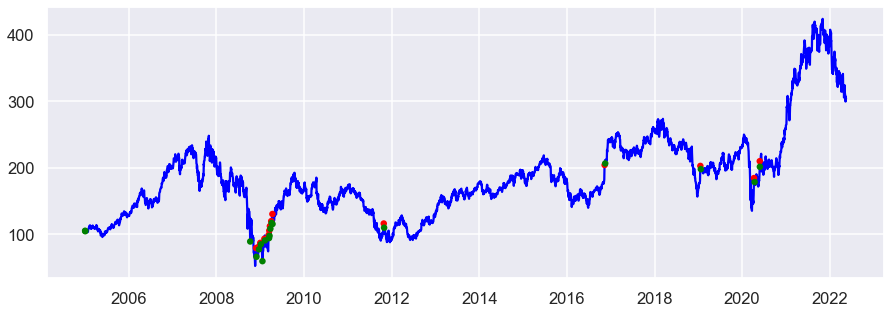

In [20]:
colors = {'buy':'green', 'sell':'red'}
df = pd.DataFrame(dict(trans_date=transaction_date, trans_price=transaction_price, trans_type = translist))
plt.figure(figsize=(15,5))
plt.scatter(df['trans_date'],df['trans_price'],s=25,c=df['trans_type'].map(colors),zorder=2)
plt.plot(datelist, pricelist, color='blue',zorder=1)



In [21]:
print(best_agent.g)

[0.20607672163818092, -0.7185289000882285, -0.1926177706072052, 0.4225725617958973, 0.3285174934314221]


In [22]:
print(transaction_price)

[104.94999694824219, 104.2699966430664, 88.80000305175781, 78.98999786376953, 65.76000213623047, 80.7300033569336, 77.0, 86.76000213623047, 84.5, 59.20000076293945, 92.8499984741211, 90.4000015258789, 98.80000305175781, 93.9000015258789, 105.25, 97.31999969482422, 111.93000030517578, 108.08000183105469, 119.4000015258789, 116.6500015258789, 130.14999389648438, 115.11000061035156, 115.86000061035156, 109.55000305175781, 203.94000244140625, 206.25999450683594, 202.5399932861328, 197.67999267578125, 184.25999450683594, 178.22999572753906, 209.66000366210938, 201.22000122070312]


In [23]:
print(daylist)

[0, 1, 950, 984, 985, 999, 1000, 1007, 1010, 1018, 1030, 1033, 1055, 1056, 1058, 1060, 1061, 1065, 1070, 1071, 1075, 1076, 1719, 1720, 2987, 2990, 3535, 3536, 3843, 3845, 3875, 3876]


In [24]:
print(transaction_date)

[Timestamp('2005-01-03 00:00:00'), Timestamp('2005-01-04 00:00:00'), Timestamp('2008-10-10 00:00:00'), Timestamp('2008-11-28 00:00:00'), Timestamp('2008-12-01 00:00:00'), Timestamp('2008-12-19 00:00:00'), Timestamp('2008-12-22 00:00:00'), Timestamp('2009-01-02 00:00:00'), Timestamp('2009-01-07 00:00:00'), Timestamp('2009-01-20 00:00:00'), Timestamp('2009-02-05 00:00:00'), Timestamp('2009-02-10 00:00:00'), Timestamp('2009-03-13 00:00:00'), Timestamp('2009-03-16 00:00:00'), Timestamp('2009-03-18 00:00:00'), Timestamp('2009-03-20 00:00:00'), Timestamp('2009-03-23 00:00:00'), Timestamp('2009-03-27 00:00:00'), Timestamp('2009-04-03 00:00:00'), Timestamp('2009-04-06 00:00:00'), Timestamp('2009-04-13 00:00:00'), Timestamp('2009-04-14 00:00:00'), Timestamp('2011-10-28 00:00:00'), Timestamp('2011-10-31 00:00:00'), Timestamp('2016-11-11 00:00:00'), Timestamp('2016-11-16 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('20

In [25]:
print(translist)

['buy', 'buy', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy', 'sell', 'buy']
